In [1]:
import joblib
import math
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn.connectome.connectivity_matrices import sym_matrix_to_vec
from neuroginius.plotting import plot_matrix

from cogpred.utils.configuration import get_config
from cogpred.utils.naming import make_run_path

config = get_config()
conn_dir = config["connectivity_matrices"]
sns.reset_defaults()


In [2]:
import sys
import os
bpath = Path(os.environ["HOME"]) / "AD-prediction"
sys.path.append(str(bpath))
from bold_dementia.data.volumes import add_volumes, load_volumes


In [3]:
ATLAS = "schaefer200"
k = 3
metadata = pd.read_csv(f"{conn_dir}/atlas-{ATLAS}_prediction/balanced_all_subs.csv", index_col=0)
labels = pd.read_csv(f"data/cluster_{k}_labels.csv", index_col=0)
fc_subjects_path = Path(config["output_dir"]) / "prediction" / "k-3_feat-fc_atlas-schaefer200/metadata.csv"
fc_subjects = pd.read_csv(fc_subjects_path, index_col=0)["sub"].to_list()

metadata = metadata[metadata.ses == "M000"]

metadata = metadata.merge(
    right=labels,
    how="inner", # Preserves order of the left key
    on="NUM_ID",
    validate="many_to_one"
)

# We only keep subjects which were used for prediction from 
# functionnal connectivity, since this is meant as a score
# for comparison
metadata = metadata[metadata["sub"].isin(fc_subjects)]

run_path = make_run_path(config["output_dir"], k=k, feat="volumetry", atlas=ATLAS)
os.makedirs(run_path, exist_ok=True)
metadata.to_csv(run_path / "metadata.csv")

In [4]:
vpath = Path(config["data_dir"]) / "volumes.csv"
df = add_volumes(metadata, vpath)

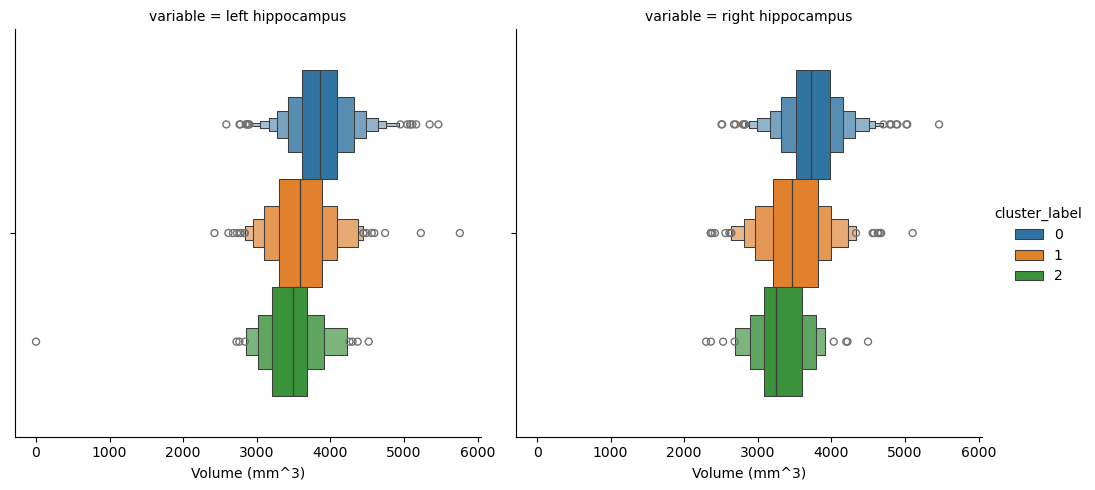

In [5]:
m = df.melt(
    id_vars=["cluster_label"],
    value_vars=["left hippocampus", "right hippocampus"],
    value_name="Volume (mm^3)"
)
sns.catplot(m, x="Volume (mm^3)", hue="cluster_label", col="variable", kind="boxen", palette="tab10")
plt.show()

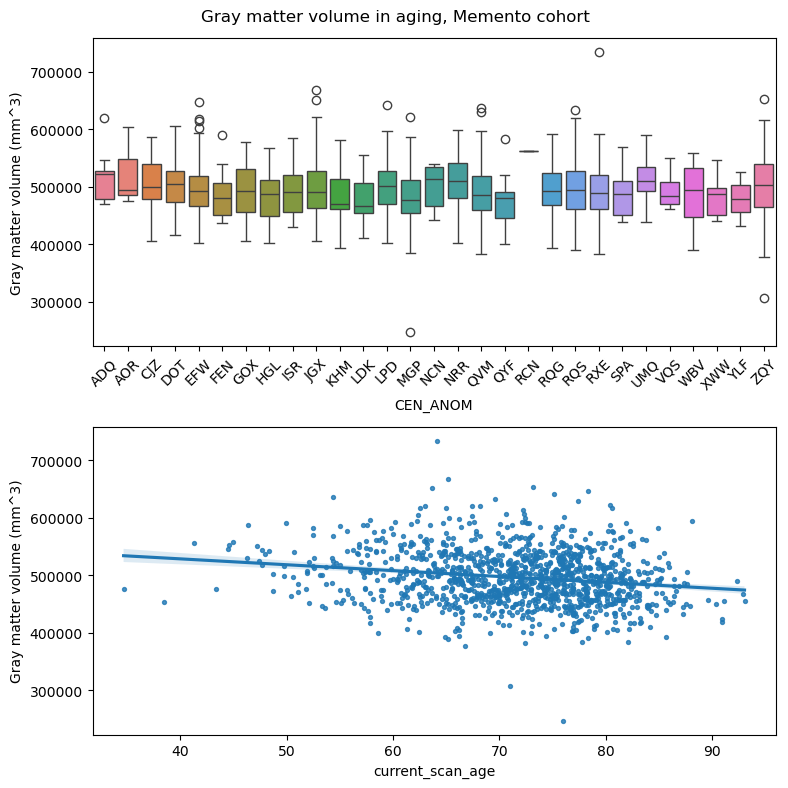

In [6]:
df["gray matter volume"] = df['left cerebral cortex'] + df['right cerebral cortex']
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharey=True)
sns.boxplot(
    df.groupby("sub").sample(n=1).sort_values(by="CEN_ANOM"),
    y='gray matter volume',
    x='CEN_ANOM',
    hue="CEN_ANOM",
    ax=ax1
)
ax1.tick_params(axis='x', labelrotation=45)

sns.regplot(
    df.groupby("sub").sample(n=1),
    x="current_scan_age",
    y='gray matter volume',
    scatter_kws=dict(s=8),
    ax=ax2
)
ax1.set_ylabel("Gray matter volume (mm^3)")
ax2.set_ylabel("Gray matter volume (mm^3)")
fig.suptitle("Gray matter volume in aging, Memento cohort")
fig.tight_layout()
plt.show()

In [7]:
y = metadata.cluster_label
assert len(df) == len(y)

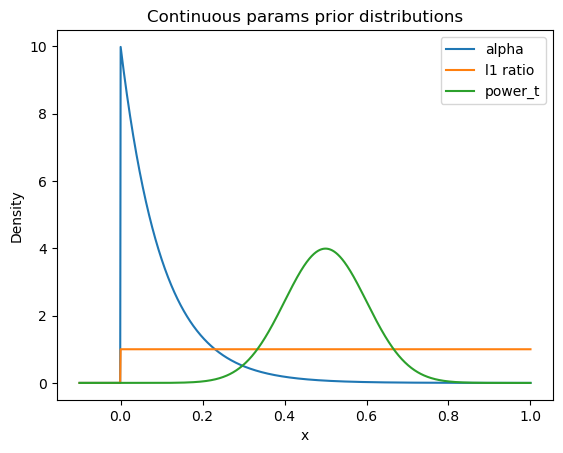

In [8]:
from scipy import stats

#lambda_param = 1 / 1e-4
lambda_param = 10
alpha_distribution = stats.expon(scale=1/lambda_param)
l1_ratio = stats.uniform(0, 1)
#l1_ratio = stats.beta(1.5, 3) # TODO Try higher l1_ratio with high n_comps
#l1_ratio = stats.expon(scale=1/7)
power_t = stats.norm(loc=0.5, scale=0.1)

x = np.linspace(-0.1, 1, 1000)
da = alpha_distribution.pdf(x)
dl = l1_ratio.pdf(x)
dt = power_t.pdf(x)

plt.plot(x, da, label="alpha")
plt.plot(x, dl, label="l1 ratio")
plt.plot(x, dt, label="power_t")
plt.title("Continuous params prior distributions")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.show()



In [9]:
param_dist = {
    "classifier__loss": ["hinge", "log_loss", "modified_huber"],
    "classifier__alpha": alpha_distribution,
    "classifier__l1_ratio": l1_ratio,
    "classifier__power_t": power_t,
}

In [10]:
# on en était ici
# TODO What timepoint? Can we be sure it's the first one?

from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn import preprocessing as preproc

cortex_selec = make_column_selector(
    pattern="ctx-.*",
    dtype_include=float
)
transformers = (
    ("cortex", preproc.StandardScaler(), cortex_selec),
    (
        "subcortical",
        preproc.StandardScaler(),
        ["left hippocampus", "right hippocampus"]
    ), # TODO Ventricles?
)
ct = ColumnTransformer(
    transformers=transformers, remainder="drop"
)

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn import preprocessing
from sklearn.model_selection import (
    cross_validate, cross_val_predict, KFold, RandomizedSearchCV, StratifiedKFold
)

from sklearn.decomposition import PCA
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.metrics import f1_score
from functools import partial

from sklearn.model_selection import cross_val_predict, KFold, RandomizedSearchCV, cross_val_score
from cogpred.supervised import macro_f1

sgd = SGDClassifier(
    penalty="elasticnet",
    class_weight="balanced", 
    random_state=1999
)

clf = Pipeline(
    [
    ("ct", ct),
    ("classifier", sgd)
    ],
    verbose=False
)

inner_cv = StratifiedKFold(n_splits=8, shuffle=True, random_state=1999)
outer_cv = StratifiedKFold(n_splits=8, shuffle=True, random_state=1999)


search = RandomizedSearchCV(
    clf,
    param_distributions=param_dist,
    n_iter=100,
    scoring=macro_f1,
    cv=inner_cv,
    random_state=1999,
    verbose=1,
    n_jobs=8,
    error_score="raise"
)

In [12]:
search.fit(df, y)
cv_results = pd.DataFrame(search.cv_results_).sort_values(by="mean_test_score", ascending=False)
cv_results

Fitting 8 folds for each of 100 candidates, totalling 800 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__alpha,param_classifier__l1_ratio,param_classifier__loss,param_classifier__power_t,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,mean_test_score,std_test_score,rank_test_score
41,0.080873,0.013442,0.009253,0.000383,0.034320,0.142226,log_loss,0.562910,"{'classifier__alpha': 0.034319934663027234, 'c...",0.490020,0.450877,0.385391,0.441121,0.443048,0.470547,0.443990,0.404473,0.441183,0.031251,1
32,0.071444,0.013104,0.008449,0.001305,0.431803,0.003925,modified_huber,0.273559,"{'classifier__alpha': 0.4318028392632946, 'cla...",0.467528,0.451513,0.382565,0.404479,0.460498,0.449235,0.437229,0.429300,0.435294,0.027160,2
11,0.214791,0.085108,0.009329,0.000298,0.039609,0.805349,modified_huber,0.536124,"{'classifier__alpha': 0.039609172429587836, 'c...",0.441449,0.416299,0.388667,0.459544,0.431767,0.438229,0.463020,0.399280,0.429782,0.025011,3
29,0.116900,0.026524,0.011309,0.004916,0.016834,0.634465,log_loss,0.587124,"{'classifier__alpha': 0.016833862856053424, 'c...",0.451743,0.427622,0.376815,0.445232,0.470189,0.447183,0.388019,0.396237,0.425380,0.031979,4
37,0.091615,0.015119,0.009771,0.000672,0.081069,0.726521,modified_huber,0.335698,"{'classifier__alpha': 0.08106891879846043, 'cl...",0.439950,0.405350,0.389500,0.405382,0.440167,0.506632,0.406183,0.408311,0.425184,0.034966,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54,0.056609,0.012672,0.009221,0.000423,0.315500,0.255865,hinge,0.717394,"{'classifier__alpha': 0.31549987382496675, 'cl...",0.288889,0.288889,0.288889,0.288889,0.287485,0.287485,0.288557,0.288557,0.288455,0.000576,79
78,0.049823,0.012095,0.009726,0.000715,0.179752,0.890041,hinge,0.625186,"{'classifier__alpha': 0.17975202621170994, 'cl...",0.288889,0.288889,0.288889,0.288889,0.287485,0.287485,0.288557,0.288557,0.288455,0.000576,79
58,0.072436,0.025502,0.011366,0.005291,0.107102,0.683930,hinge,0.423776,"{'classifier__alpha': 0.10710241069441317, 'cl...",0.288889,0.288889,0.288889,0.288889,0.287485,0.287485,0.288557,0.288557,0.288455,0.000576,79
70,0.052409,0.015506,0.012927,0.005634,0.228173,0.834925,hinge,0.441116,"{'classifier__alpha': 0.22817275444301358, 'cl...",0.288889,0.288889,0.288889,0.288889,0.287485,0.287485,0.288557,0.288557,0.288455,0.000576,79


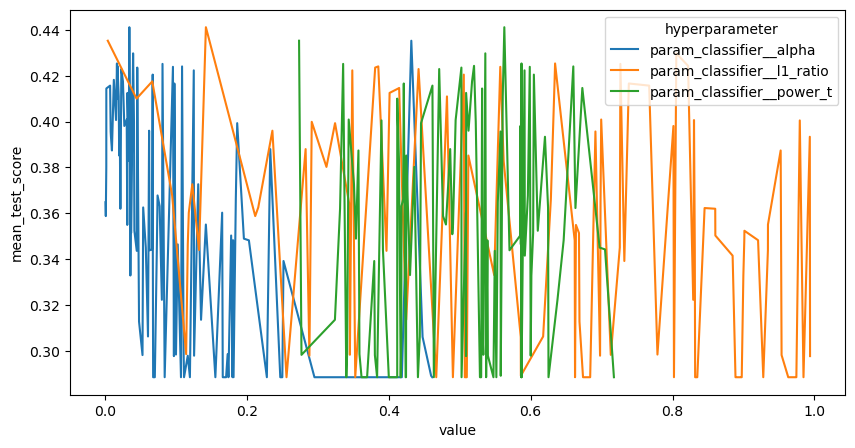

In [13]:
m = cv_results.melt(
    id_vars='mean_test_score',
    value_vars=[
        "param_classifier__alpha",
        "param_classifier__l1_ratio",
        "param_classifier__power_t"
    ],
    var_name="hyperparameter"
)
plt.subplots(figsize=(10, 5))
sns.lineplot(
    m,
    x="value",
    y="mean_test_score",
    hue="hyperparameter"
)
plt.show()

In [14]:
test_scores = cross_val_score(
    search, df, y, cv=outer_cv, n_jobs=8, scoring=macro_f1, verbose=1
) # TODO Get hyperparameters
test_scores

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 8 folds for each of 100 candidates, totalling 800 fits
Fitting 8 folds for each of 100 candidates, totalling 800 fits
Fitting 8 folds for each of 100 candidates, totalling 800 fits
Fitting 8 folds for each of 100 candidates, totalling 800 fits
Fitting 8 folds for each of 100 candidates, totalling 800 fits
Fitting 8 folds for each of 100 candidates, totalling 800 fits
Fitting 8 folds for each of 100 candidates, totalling 800 fits
Fitting 8 folds for each of 100 candidates, totalling 800 fits


/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/homes_unix/jlegrand/miniconda3/envs/cogpred/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Co

array([0.44144915, 0.43247944, 0.38607199, 0.44336265, 0.43233471,
       0.47054712, 0.39376152, 0.34496446])

In [15]:
from sklearn.dummy import DummyClassifier
baseline_scores = cross_val_score(
    DummyClassifier(), df, y, cv=outer_cv, n_jobs=8, scoring=macro_f1, verbose=1
) # TODO Get hyperparameters
import joblib
dummy_run_path = make_run_path(config["output_dir"], k=k, feat="dummy")
os.makedirs(dummy_run_path, exist_ok=True)
joblib.dump(baseline_scores, dummy_run_path / "test_scores.joblib")

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished


['/homes_unix/jlegrand/data/Memento/output/prediction/k-3_feat-dummy/test_scores.joblib']

In [16]:
import joblib
joblib.dump(test_scores, run_path / "test_scores.joblib")
joblib.dump(search.best_estimator_, run_path / "best_estimator.joblib")

['/homes_unix/jlegrand/data/Memento/output/prediction/k-3_feat-volumetry_atlas-schaefer200/best_estimator.joblib']